<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/eywalker/LVIV-2021/blob/main/notebooks/DeepLearing%20in%20Neuroscience.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/eywalker/LVIV-2021/blob/main/notebooks/DeepLearing%20in%20Neuroscience.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Welcome to Deep Learning in Neuroscience by Edgar Y. Walker

This is a Jupyter notebook to accompany the course on "Deep Learning in Neuroscience" taught as part of the Lviv Data Science Summer School 2021. This notebook as well as any other relevant information can be found in the [GitHub repository](https://github.com/eywalker/lviv-2021)!

In this course, we will learn how deep learning is getting utilized in studying neuroscience, specifically in building models of neuronal responses to complex sensory inputs such as natural images. We will start by going through some neuroscience primer in slides. We will then get our hands dirty by taking real neuronal responses recorded from mouse primary visual cortex (V1) as the mouse observes a bunch of natural images and developing models to predict these responses. By the end of this course, you will gain basic familiarity in utilizing deep learning models to predict responses of 1000s of neurons to natural images!

## Preparing the environment

#### <font color='red'>NOTE: Please run this section at the very beginning of the first session!</font>

Before we get to dive in and learn how deep learning is used in neuroscience and get your first neural predictive model trained, we need to install some prerequisite packages and download some neuronal data!

### Getting the code

We are going to primarily use [PyTorch](https://pytorch.org) to build, train and evaluate our deep learning models and I am going to assume some familiarity with PyTorch already.

Also to be able to handle the dataset containing neuronal activities, we are going to make our life easier by using a few existing libraries. I have prepared a library called [Lviv-2021](https://github.com/eywalker/lviv-2021). This library has a dependency on [neuralpredictors](https://github.com/sinzlab/neuralpredictors), which is a collection of PyTorch layers, tools and other utilities that would prove helpful to train networks to predict neuronal responses prepared by [Sinz Lab](https://sinzlab.org/).

Let's go ahead and install this inside the Colab environment (you can skip this if you are running this inside a Docker environment).

In [ ]:
# Install PyTorch dependency
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
    
# Install 
!pip3 install git+https://github.com/eywalker/lviv-2021.git

### Getting the dataset

We are going to use the dataset made available for our recent paper [Lurz et al. ICLR 2021](https://github.com/sinzlab/Lurz_2020_code), predicting responses of mouse visual cortex to natural images. 

The dataset can take anywhere from 5-10 min to download, so please be sure to **run the following at the very beginning of the session!** We are going to first spend some time learning the basics of neuroscience and it would be best that you let the download take place during that time!

To download the data, simply execute the following cell, and let it run till completion.

In [ ]:
!git clone https://gin.g-node.org/cajal/Lurz2020.git /content/data

# Slide presentation on primer on computational neuroscience

Come back to complete the rest of the notebook after the slide presentation.

# Developing models of neural population responses to natural images

Now that you have been primed with some background neuroscience knowledge, let's get our hands dirty and try to build our first neural predictive model.

As part of the setup, we have downloaded a 2-photon imaging dataset from mouse primary visual cortex as we present 1000s of natural images (if not done yet, please do so immediately by stepping through the beginning sections of this notebook).

Let's go ahead and import a bunch of standard libraries that'll prove useful in exploring our data.

In [36]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns

## Navigating the neuroscience data

As with any data science project, you must start by understanding your data! Let's take some time to navigate the data you downloaded.

In [2]:
ls ./data/static20457-5-9-preproc0/

change.log  config.json  data/  meta/


In [3]:
ls ./data/static20457-5-9-preproc0/data

behavior/  images/  pupil_center/  responses/


In [4]:
ls ./data/static20457-5-9-preproc0/data/responses | head -30

0.npy
1.npy
10.npy
100.npy
1000.npy
1001.npy
1002.npy
1003.npy
1004.npy
1005.npy
1006.npy
1007.npy
1008.npy
1009.npy
101.npy
1010.npy
1011.npy
1012.npy
1013.npy
1014.npy
1015.npy
1016.npy
1017.npy
1018.npy
1019.npy
102.npy
1020.npy
1021.npy
1022.npy
1023.npy
ls: write error: Broken pipe


In [5]:
ls ./data/static20457-5-9-preproc0/data/images | head -30

0.npy
1.npy
10.npy
100.npy
1000.npy
1001.npy
1002.npy
1003.npy
1004.npy
1005.npy
1006.npy
1007.npy
1008.npy
1009.npy
101.npy
1010.npy
1011.npy
1012.npy
1013.npy
1014.npy
1015.npy
1016.npy
1017.npy
1018.npy
1019.npy
102.npy
1020.npy
1021.npy
1022.npy
1023.npy
ls: write error: Broken pipe


You can see that both responses and images are contained in collections of `numpy` files named like `1.npy` or `31.npy`. The number here corresponds to a specific **trial** or simply different image presentation during an experiment.

Let's take a look at some of these files.

### Loading data files one at a time

Let's pick some trial and load the image as well as the response

In [7]:
trial_idx = 1100
trial_image = np.load(f'./data/static20457-5-9-preproc0/data/images/{trial_idx}.npy')
trial_responses = np.load(f'./data/static20457-5-9-preproc0/data/responses/{trial_idx}.npy')

The image is shaped as $\text{channel} \times \text{height} \times \text{width}$

In [8]:
trial_image.shape

(1, 36, 64)

(-0.5, 63.5, 35.5, -0.5)

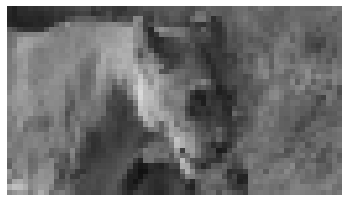

In [9]:
plt.imshow(trial_image.squeeze(), cmap='gray', vmin=0, vmax=255)
plt.axis('off')

In contrast, the shape of `trial_response` is simply the number of neurons

In [12]:
trial_responses.shape

(5335,)

In [13]:
trial_responses.min() # responses are practically always >= 0

-5.409307320414307e-10

In [14]:
trial_responses.max()

53.39189366955226

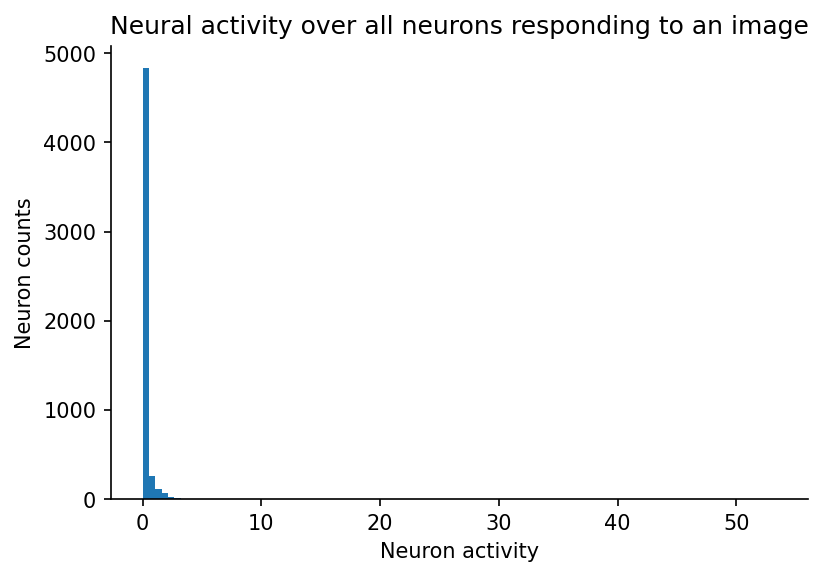

In [41]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.hist(trial_responses, 100);
ax.set_title('Neural activity over all neurons responding to an image')
ax.set_xlabel('Neuron activity')
ax.set_ylabel('Neuron counts')
sns.despine()

You can see most neuron's responses stay very close to 0 - signifying no activity.

### Loading the entire dataset

While we can inspect the image and the corresponding neural population responses one image at a time, this is quite cumbersome and also impractical for use in network training. Fortunately, the `lviv` package provides us with a convenience function that will help to load the entire dataset as PyTorch dataloaders.

In [18]:
from lviv.dataset import load_dataset

As we prepare the dataloaders, we get to specify the batch size.

In [19]:
dataloaders = load_dataset(path = './data/static20457-5-9-preproc0', batch_size=60)

The function returns a dictionary consisting of three dataloaders for training, validation, and test set.

In [20]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1100aeee80>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7f1100879400>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f1100879310>}

Let's specifically look at the trainset dataloader

In [21]:
train_loader = dataloaders['train']

Total number of images can be checked as follows:

In [22]:
len(train_loader.sampler)

4472

We can inspect what it returns per batch:

In [23]:
images, responses = next(iter(train_loader))

In [24]:
images.shape

torch.Size([60, 1, 36, 64])

In [25]:
responses.shape

torch.Size([60, 5335])

As expected, you can see it returns a batch size of 60 images and responses for all neurons.

Similar inspection can be done on the **validation** and **testing** dataloaders.

In [26]:
# number of images in validation set
len(dataloaders['validation'].sampler)

522

In [27]:
# number of images in test set
len(dataloaders['test'].sampler)

999

You might think that we have a lot of images in test set, but this is because test set consists of repeated images.

Some additional trial information can be observed by accessing the underlying PyTorch dataset object and looking at the `trial_info`. Note that this is not part of the standard PyTorch dataset/dataloader interface, but rather a feature specifically provided by our `lviv` library!

In [29]:
# Access to the dataset object that underlies all dataloaders
dataset = dataloaders['test'].dataset

In [30]:
# get trials that are marked as "test" set
test_trials = np.where(dataset.trial_info['tiers'] == 'test')[0]

In [31]:
# get information about the presented image for ALL trials
image_ids = dataset.trial_info['frame_image_id']

In [32]:
# find IDs of all unique images presented during test trials
unique_test_images = np.unique(image_ids[test_trials])
unique_test_images

array([ 104,  128,  183,  355,  479,  483,  656,  803,  830,  936, 1201,
       1494, 1596, 1652, 1656, 1682, 1731, 1756, 1796, 2005, 2008, 2014,
       2159, 2214, 2389, 2586, 2710, 2746, 2747, 2803, 2816, 2825, 2954,
       3018, 3107, 3144, 3163, 3372, 3427, 3438, 3487, 3507, 3562, 3702,
       3847, 3924, 4231, 4295, 4373, 4397, 4400, 4430, 4594, 4619, 4667,
       4674, 4717, 4739, 4782, 4812, 4814, 4821, 4923, 4953, 5034, 5128,
       5166, 5225, 5264, 5288, 5322, 5334, 5399, 5402, 5504, 5640, 5671,
       5679, 5754, 5782, 6013, 6034, 6066, 6082, 6205, 6238, 6248, 6490,
       6562, 6773, 6790, 6831, 6886, 7017, 7028, 7107, 7119, 7120, 7154,
       7495])

In [34]:
len(unique_test_images)

100

We can see that the test set consists of 100 unique images, each repeated up to 10 times.

Let's now take a look at how a neuron responds to these repeated presentations of an identical image.

In [62]:
# noisiness of neural responses: plot one neuron's responses to 20 images (x axis) each shown 10 repeats (y axis)
import pandas as pd
condition_hash = np.load(
    "/content/data/static20457-5-9-preproc0/meta/trials/condition_hash.npy"
)
responses = [
    np.load(f"/content/data/static20457-5-9-preproc0/data/responses/{i}.npy")
    for i in range(len(condition_hash))
]

df = pd.DataFrame({"condition_hash": condition_hash, "response": responses})
df['repeats'] = df.groupby("condition_hash").transform('count')
df = df.loc[df['repeats'] == 10]  # only keep trials with 10 repeats

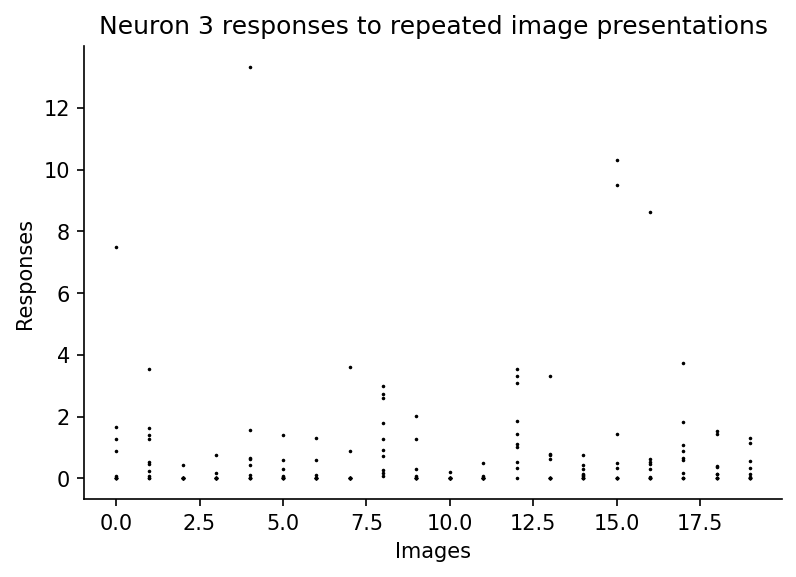

In [63]:
neuron_idx = 3  # choose one neuron to inspect its responses

fig, ax = plt.subplots(1, 1, dpi=150)
for i, (_, repeats) in enumerate(list(df.groupby("condition_hash"))[:20]):
    ax.scatter(np.ones(10) * i, np.stack(repeats.response)[:, neuron_idx], c='k', s=0.5)
ax.set_title(f'Neuron {neuron_idx} responses to repeated image presentations')
ax.set_xlabel('Images')
ax.set_ylabel('Responses')
sns.despine()

You can see that indeed a single neuorn's responses vary widely even to repeated presentations of an identical stimulus! This **noiseness** of neural responses make predicting the respones of the neurons to images fundamentally challenging and also esssentially make it impossible to yield perfect fit! Instead, we would often try to fit the **distribution of responses** the best we can, and we will briefly visit this point later.

# Modeling the neuronal responses

Now that we have successfully loaded the dataset and inspected its contents, it's time for us to start **modeling** the responses.

We will start by building a very basic **Linear-Nonlinear model** - which is nothing more than a shallow neural network with single linear layer followed by an activation function.

## Linear-Nonlinear (LN) model

### Background

Arguably one of the simplest model of a neuron's response to a stimulus is the **linear-nonlinear (LN) model**. 

Given an image $I \in \mathbb{R}^{h\,\times\,w}$ where $h$ and $w$ are the height and the width of the image, respectively, let us collapse the image into a vector $x \in \mathbb{R}^{hw}$.

A single neuron's response $r$ under linear-nonlinear model can then be expressed as:
$$
r = a(u^\top x + b),
$$
where $u \in \mathbb{R}^{hw}$ and $b \in \mathbb{R}$ are **weight** and **bias**, and $a:\mathbb{R}\mapsto\mathbb{R}$ is a scalar **activating function**.

We can in fact extend to capture the responses of all $N$ neurons simultaneously as:

$$
\mathbf{r} = a(\mathbf{U} x + \mathbf{b}),
$$
where $\mathbf{r} \in \mathbb{R}^{N}$, $\mathbf{U} \in \mathbb{R}^{N\,\times\,hw}$ and $\mathbf{b} \in \mathbb{R}^{N}$.

Hence, each neuron weighs each pixel of the image according to the weight $u$ (corresopnds to a row of $\mathbf{U}$) and thus characterizes how much the each neuron "cares" about a specific pixel.

The weight $u$ can be thought of as a **filter** that's the same size as the image and is overlaid on top of the image to determine what pixel would contribute to the neuron's response. 

This *image filter* is typically referred to as the **receptive field** of the neuron!

The nonlinear activation function $a(\cdot)$ ensures, among other things, that the output of the network stays above 0. In fitting neuronal responses, we tend to use $a(x) = ELU(x) + 1$ where ELU (Exponential Linear Unit) is defined as follows:

$$
    ELU(x) = 
\begin{cases}
    e^x - 1, & x \lt 0 \\
    x,   & x \ge 0
\end{cases}
$$

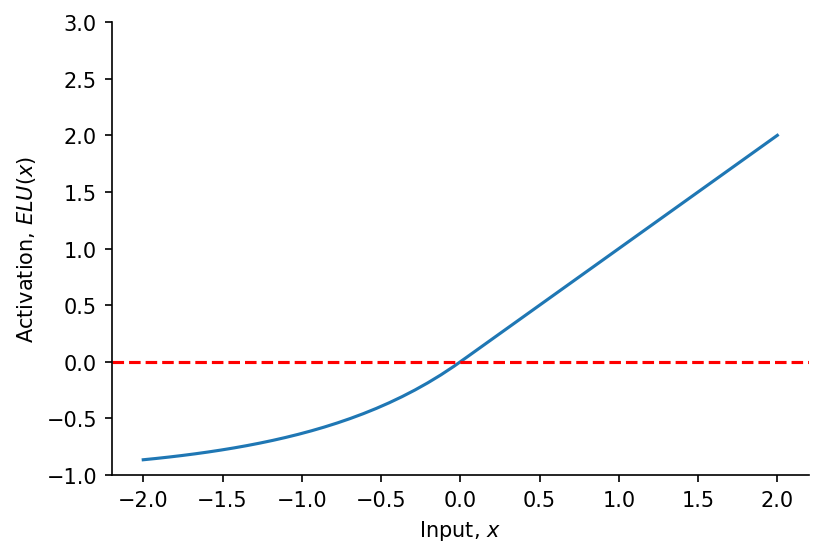

In [49]:
# Plotting ELU function
fig, ax = plt.subplots(1, 1, dpi=150)
x = np.linspace(-2, 2)
ax.plot(x, F.elu(torch.Tensor(x)))
ax.axhline(0, c='r', ls='--')
ax.set_xlabel(r'Input, $x$')
ax.set_ylabel(r'Activation, $ELU(x)$')
ax.set_ylim([-1, 3])
sns.despine()

We shift it by 1 to ensure it will always remain positive

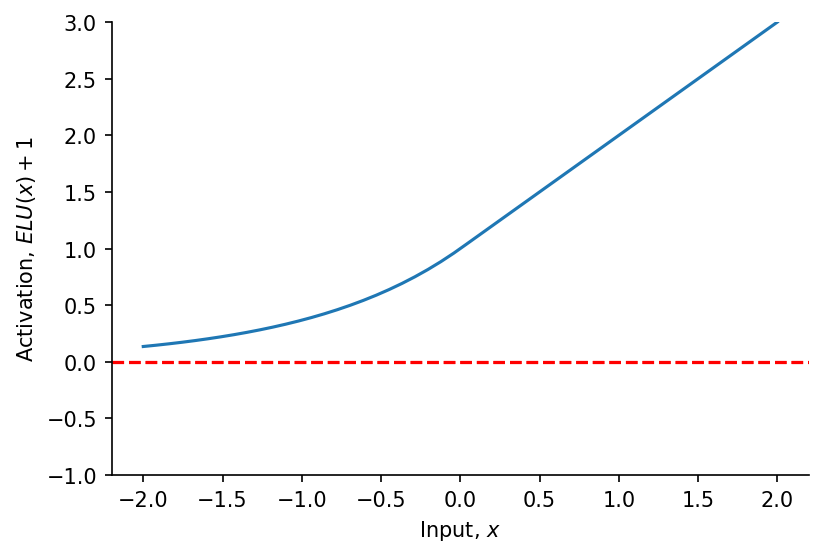

In [50]:
# Plotting ELU+1 function
fig, ax = plt.subplots(1, 1, dpi=150)
x = np.linspace(-2, 2)
ax.plot(x, F.elu(torch.Tensor(x))+1)
ax.axhline(0, c='r', ls='--')
ax.axhline(0, c='r', ls='--')
ax.set_xlabel(r'Input, $x$')
ax.set_ylabel(r'Activation, $ELU(x) + 1$')
ax.set_ylim([-1, 3.0])
sns.despine()

Overall, it can be seen that a linear-nonlinear (LN) model is nothing more than a single linear layer applied on a flattened image input, followed by a nonlinear activation function (i.e. $ELU(x)+1$). 

Now let's go ahead and implment our LN model in PyTorch!

### Implementation

We implement a simple network consisting of a linear layer followed by ELU + 1 activation

In [78]:
class Linear(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        momentum=0.1,
        init_std=1e-3,
        gamma=0.0,
    ):
        super().__init__()
        self.bn = nn.BatchNorm2d(1, momentum=momentum, affine=False)
        self.linear = nn.Linear(input_height * input_width, n_neurons)
        self.gamma = gamma
        self.init_std = init_std
        self.initialize()
        
    
    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x.flatten(1))
        return nn.functional.elu(x) + 1
        

    def initialize(self, std=None):
        if std is None:
            std = self.init_std
        nn.init.normal_(self.linear.weight.data, std=std)


    def regularizer(self):
        return self.gamma * self.linear.weight.abs().sum()


And that's it! We have now designed our first network model of the neuron's responses!

**BONUS**: notice that we used batch normalization (BN) layer right before the linear layer? This empirically helps to stabilize the training, allowing us to be not too sensitive to the weight and bias initialization. You could totally implement and train a LN network without such BN layer and you are more than welcome to try! However if you do, be very aware of the network weight initializations and the chocie of learning rate during the training.

Finally, let's instantiate the model before we move onto the next step of training the model!

In [79]:
ln_model = Linear(input_height=64, input_width=36, n_neurons=5335, gamma=0.1)

### Training the network

Now that we have a candidate model designed, it's time to train it. While we could use standard set of optimizers as provided by PyTorch to implement our training routine, here we are provided with a convenience function `train_model` that would handle a lot of the training boiler plate.

In [80]:
from lviv.trainers import train_model

Critically, `train_model` sets up the training based on **Poisson loss** and also perform early stopping based on **correlation** of the predicted neuronal responses with the actual neuronal responses on the **validation set**. Let's now talk briefly about our objective (loss) function of choice in training neuron response models - the Poisson loss.

### Mathematical aside: Poisson Loss

#### How we are **actually** modeling the noisy neuronal responses

The use of **Poisson loss** follows from the assumption that, *conditioned on the stimulus*, the neurons' responses follow an **independent Poisson** distribution. That is, given an input image $x$, the population response $\mathbf{r}$ is distributed as:

$$
p(\mathbf{r} | x) = \prod_i^N \text{Poiss}(r_i; \lambda_i(x))
$$

where $r_i$ is the $i^\text{th}$ neuron in the population $\mathbf{r}$. The $\lambda_i$ is the parameter for Poisson distribution that controls its **average value**. Here we express $\lambda_i(x)$ to indicate the fact that the average response for each neuron is expected to vary *as a function of the input image*. We can express this average matching as:

$$
\mathbb{E}[r_i|x] = \lambda_i(x)
$$

In fact, it is precisely this function $\lambda_i(x)$ that we are modeling using LN models and, in the next step, more complex neural networks. In otherwords, we are learning $\lambda_i(x) = f_i(x, \theta)$, where $\theta$ is the trainable parameters of the model.

Putting all together, this means that, our model $f(x, \theta)$ is really modeling the average activity of the neurons,

$$
\mathbb{E}[\mathbf{r}|x] = \mathbf{f}(x, \theta)
$$

while we are assuming that the neurons are distributed according to **independent Poisson** distribution around the average responses predicted by our model $\mathbf{f}(x, \theta)$.

#### Deriving the objective function

Poisson distribution is defined as follows:

$$
p(r) = \text{Poiss}(r; \lambda) = \frac{e^{-\lambda}\lambda^{r}}{r!}
$$

During the training, we would want to adjust the model parameter $\theta$ to maximize the chance of observing the response $\mathbf{r}$ to a known image $x$. This is achieved by **maximizing** the log-likelihood function $\log p(\mathbf{r}|x, \theta)$, or equivalently by **minimzing the negative log-likelihood function** as the objective function $L(x, \mathbf{r}, \theta)$:

$$
\begin{align}
L(x, \mathbf{r}, \theta) &= -\log p(\mathbf{r}|x, \theta) \\
&= -\log \prod_i \text{Poiss}(r_i; f_i(x, \theta)) \\
&= -\sum_i \log \frac{e^{-f_i(x, \theta)}f_i(x, \theta)^{r_i}}{r_i!} \\
&= \sum_i \left(f_i(x, \theta) - r_i \log f_i(x, \theta) + \log r_i! \right)
\end{align}
$$


During the optimization, we seek for $\theta$ that would minimize the loss $L$. Note that since the term $\log r_i!$ does not depend on $\theta$, it can be safely dropped from Poisson loss. Hence you would commonly see the following expression as the definition of the **Poisson loss**

$$
L_\text{Poiss}(x, \mathbf{r}, \theta) = \sum_i \left(f_i(x, \theta) - r_i \log f_i(x, \theta)\right)
$$

### Performing the training

Now that we have the theoretical foundation for the training and the choice of the objective function under our belt, let's go ahead and train the network. Because the function `train_model` handles a lot underneath the hood, training a model is just as easy as invoking the function by passing it the model to be trained and the dataloaders!

In [81]:
from lviv.trainers import train_model

In [82]:
score, output, model_state = train_model(model=ln_model, dataloader=dataloaders)

correlation -0.0028376007
poisson_loss 9536425.0


Epoch 1: 100%|██████████| 75/75 [00:04<00:00, 15.25it/s]


[001|00/05] ---> 0.06291262805461884
correlation 0.06291263
poisson_loss 3233414.0


Epoch 2: 100%|██████████| 75/75 [00:00<00:00, 82.23it/s]


[002|00/05] ---> 0.07530715316534042
correlation 0.07530715
poisson_loss 2823158.8


Epoch 3: 100%|██████████| 75/75 [00:00<00:00, 84.48it/s]


[003|00/05] ---> 0.08148764073848724
correlation 0.08148764
poisson_loss 2646291.5


Epoch 4: 100%|██████████| 75/75 [00:00<00:00, 79.08it/s]


[004|01/05] -/-> 0.07675723731517792
correlation 0.07675724
poisson_loss 2614737.5


Epoch 5: 100%|██████████| 75/75 [00:00<00:00, 84.55it/s]


[005|01/05] ---> 0.0831238180398941
correlation 0.08312382
poisson_loss 2618676.0


Epoch 6: 100%|██████████| 75/75 [00:00<00:00, 84.46it/s]


[006|00/05] ---> 0.08651387691497803
correlation 0.08651388
poisson_loss 2535143.0


Epoch 7: 100%|██████████| 75/75 [00:00<00:00, 84.79it/s]


[007|00/05] ---> 0.08859601616859436
correlation 0.088596016
poisson_loss 2492160.0


Epoch 8: 100%|██████████| 75/75 [00:00<00:00, 82.08it/s]


[008|00/05] ---> 0.0907663106918335
correlation 0.09076631
poisson_loss 2553214.2


Epoch 9: 100%|██████████| 75/75 [00:01<00:00, 74.58it/s]


[009|01/05] -/-> 0.08925200253725052
correlation 0.089252
poisson_loss 2550302.2


Epoch 10: 100%|██████████| 75/75 [00:00<00:00, 83.80it/s]


[010|02/05] -/-> 0.08571925759315491
correlation 0.08571926
poisson_loss 2573360.5


Epoch 11: 100%|██████████| 75/75 [00:00<00:00, 80.87it/s]


[011|03/05] -/-> 0.08661939948797226
correlation 0.0866194
poisson_loss 2674216.0


Epoch 12: 100%|██████████| 75/75 [00:00<00:00, 78.25it/s]


[012|04/05] -/-> 0.08475182950496674
correlation 0.08475183
poisson_loss 2640827.0


Epoch 13: 100%|██████████| 75/75 [00:00<00:00, 84.00it/s]


[013|05/05] -/-> 0.08563712239265442
Restoring best model after lr decay! 0.085637 ---> 0.090766
correlation 0.09076631
poisson_loss 2553214.2


Epoch 14: 100%|██████████| 75/75 [00:00<00:00, 83.38it/s]


Epoch    14: reducing learning rate of group 0 to 1.5000e-03.
[014|01/05] -/-> 0.08135292679071426
correlation 0.08135293
poisson_loss 2619570.5


Epoch 15: 100%|██████████| 75/75 [00:00<00:00, 78.23it/s]


[015|01/05] ---> 0.1087164357304573
correlation 0.108716436
poisson_loss 2224880.0


Epoch 16: 100%|██████████| 75/75 [00:00<00:00, 83.09it/s]


[016|01/05] -/-> 0.10778597742319107
correlation 0.10778598
poisson_loss 2203862.2


Epoch 17: 100%|██████████| 75/75 [00:00<00:00, 81.61it/s]


[017|02/05] -/-> 0.10817896574735641
correlation 0.108178966
poisson_loss 2206134.0


Epoch 18: 100%|██████████| 75/75 [00:00<00:00, 79.73it/s]


[018|03/05] -/-> 0.10457243025302887
correlation 0.10457243
poisson_loss 2235500.5


Epoch 19: 100%|██████████| 75/75 [00:00<00:00, 83.66it/s]


[019|04/05] -/-> 0.10566174983978271
correlation 0.10566175
poisson_loss 2214932.5


Epoch 20: 100%|██████████| 75/75 [00:00<00:00, 76.61it/s]


[020|05/05] -/-> 0.10366460680961609
Restoring best model after lr decay! 0.103665 ---> 0.108716
correlation 0.108716436
poisson_loss 2224880.0


Epoch 21: 100%|██████████| 75/75 [00:00<00:00, 84.06it/s]


Epoch    21: reducing learning rate of group 0 to 4.5000e-04.
[021|01/05] -/-> 0.10407443344593048
correlation 0.10407443
poisson_loss 2212213.8


Epoch 22: 100%|██████████| 75/75 [00:00<00:00, 83.28it/s]


[022|01/05] ---> 0.1141660287976265
correlation 0.11416603
poisson_loss 2135080.5


Epoch 23: 100%|██████████| 75/75 [00:00<00:00, 79.38it/s]


[023|00/05] ---> 0.1154339537024498
correlation 0.11543395
poisson_loss 2140812.5


Epoch 24: 100%|██████████| 75/75 [00:00<00:00, 83.30it/s]


[024|01/05] -/-> 0.11267277598381042
correlation 0.112672776
poisson_loss 2145623.5


Epoch 25: 100%|██████████| 75/75 [00:00<00:00, 84.19it/s]


[025|02/05] -/-> 0.11420059949159622
correlation 0.1142006
poisson_loss 2142161.2


Epoch 26: 100%|██████████| 75/75 [00:00<00:00, 84.52it/s]


[026|03/05] -/-> 0.11442482471466064
correlation 0.114424825
poisson_loss 2131446.8


Epoch 27: 100%|██████████| 75/75 [00:00<00:00, 83.87it/s]


[027|04/05] -/-> 0.11402616649866104
correlation 0.11402617
poisson_loss 2143431.0


Epoch 28: 100%|██████████| 75/75 [00:00<00:00, 83.13it/s]


[028|05/05] -/-> 0.11184372752904892
Restoring best model after lr decay! 0.111844 ---> 0.115434
Restoring best model! 0.115434 ---> 0.115434


### Analyzing the trained network

Woohoo! We have now successfully trained our very first LN model on real neuronal responses! But really, how good is the model?

During the training, the `train_model` function iteratively reported two values: the loss function (Poisson loss) value and the average correlation. 

But what is this correlation? It's simply the correlation computed between our predicted neuronal responses $\hat{r}_i$ and the actual neuronal responses $r_i$ across images in the validation set. We then take the average correlation value **across neurons** to get average correlation.

Being a correlation, the highest possible value is of course 1.0. Practically speaking, this is never reached both due to 1) imperfection of our model and more fundamentally due to 2) the noiseness of the neuron's responses. Because of the noise, even a perfect model would never reach a correlation of 1.0.

Let's actually go ahead and look at the model's predicted responses on the test set and compare them against the actual responses. The package `lviv` provides for a convenient function to quickly gather the model's responses and the actual responses.

In [173]:
from lviv.utility import measures
from scipy.stats import pearsonr

actual_responses, model_responses = measures.model_predictions(ln_model, dataloaders['test'], device='cuda')

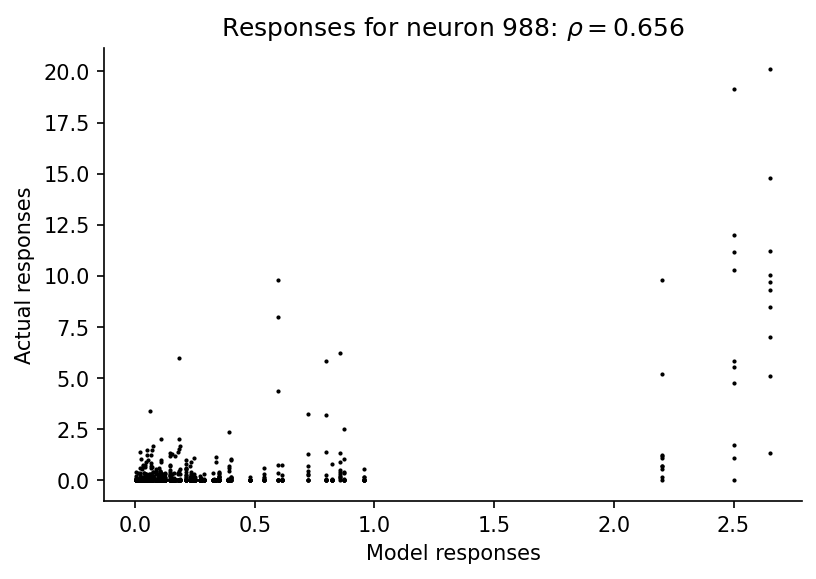

In [176]:
# pick a neuron to generate the plot for
neuron_idx = 988

# compute Pearson correlation
r, _ = pearsonr(model_responses[:, neuron_idx], actual_responses[:, neuron_idx])
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(model_responses[:, neuron_idx], actual_responses[:, neuron_idx], c='k', s=1.0)
ax.set_title(f'Responses for neuron {neuron_idx}: $\\rho = {r:.3f}$')
ax.set_xlabel('Model responses')
ax.set_ylabel('Actual responses')
sns.despine()

Let's take a look at how this correlation is distributed across neurons. This time, we'll use `get_gorrelations` function to compute correation for all neurons quickly.

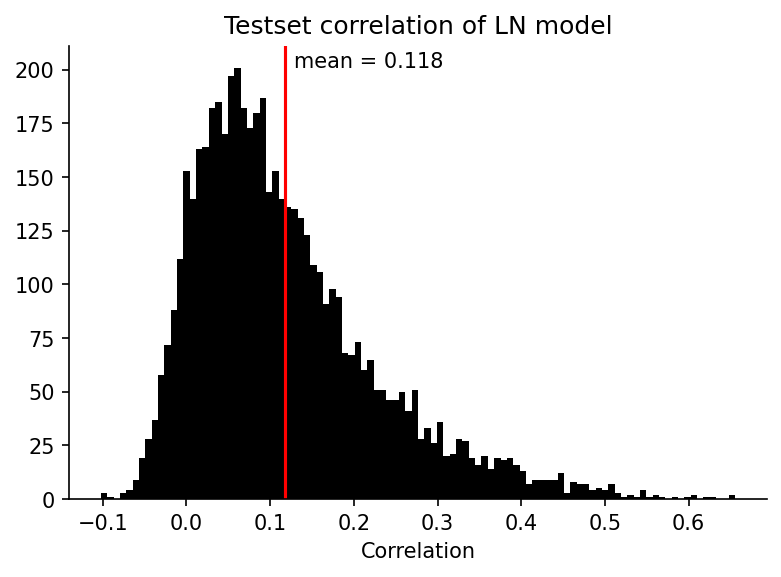

In [186]:
# compute correlation on test set
ln_test_correlations = measures.get_correlations(
    ln_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(ln_test_correlations, bins=100, color='k')
ax.axvline(np.mean(ln_test_correlations), color="r")
ax.text(
    x=np.mean(ln_test_correlations) + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(np.mean(ln_test_correlations)),
)
ax.set_title('Testset correlation of LN model')
ax.set_xlabel('Correlation')
sns.despine()

You can see that value of achieved correlation on the test set widely varies among the neurons. Some neurons are quite well predicted, reaching correlation above 0.6, where as many neurons have correlation well below 0.1.

## Going beyond Linear-Nonlinear model by using CNN

We saw that a simple LN model can be trained to achieve above chance performance in predicting the responses of mouse V1 neurons to natural images. But we certainly must be able to do better than that, right?

In the past decase, what has really driven system identification of visual neurons has been the use of convolutional neural networks (CNN). Below, we will try out a very simple CNN to see if we can already reach better performance than LN.

In [179]:
from collections import OrderedDict
class CNN(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        momentum=0.1,
        init_std=1e-3,
        gamma=0.1,
        hidden_channels=8,
    ):
        super(CNN, self).__init__()
        self.init_std = init_std
        self.gamma = gamma

        # CNN core
        self.cnn_core = nn.Sequential(
            OrderedDict(
                [
                    ("conv1", nn.Conv2d(1, hidden_channels, 15, padding=15 // 2, bias=False)),
                    ("bn1", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu1", nn.ELU()),
                    ("conv2", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn2", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu2", nn.ELU()),
                    ("conv3", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn3", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu3", nn.ELU()),
                    ("conv4", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn4", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu4", nn.ELU()),
                ]
            )
        )

        # Fully connected readout
        self.readout = nn.Sequential(
            OrderedDict(
                [
                    ('fc_ro', nn.Linear(input_height * input_width * hidden_channels, n_neurons)),
                    ('bn_ro', nn.BatchNorm1d(n_neurons, momentum=momentum)),
                ]
            )
        )


    def initialize(self, std=None):
        if std is None:
            std = self.init_std
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, std=std)

    def forward(self, x):
        x = self.cnn_core(x)
        x = x.view(x.size(0), -1)
        x = self.readout(x)
        return nn.functional.elu(x) + 1
    
    def regularizer(self):
        return self.readout[0].weight.abs().sum() * self.gamma


Let us now instantiate the model and train it!

In [88]:
cnn_model = CNN(input_height=64, input_width=36, n_neurons=5335)
score, output, model_state = train_model(model=cnn_model, dataloader=dataloaders)

correlation -0.00045015095
poisson_loss 4177012.8


Epoch 1: 100%|██████████| 75/75 [00:04<00:00, 15.26it/s]


[001|00/05] ---> 0.053945496678352356
correlation 0.053945497
poisson_loss 2966264.5


Epoch 2: 100%|██████████| 75/75 [00:04<00:00, 15.51it/s]


[002|00/05] ---> 0.10886244475841522
correlation 0.108862445
poisson_loss 2061814.6


Epoch 3: 100%|██████████| 75/75 [00:04<00:00, 15.41it/s]


[003|00/05] ---> 0.14153477549552917
correlation 0.14153478
poisson_loss 1919906.2


Epoch 4: 100%|██████████| 75/75 [00:04<00:00, 15.29it/s]


[004|00/05] ---> 0.1499428153038025
correlation 0.14994282
poisson_loss 1901764.0


Epoch 5: 100%|██████████| 75/75 [00:04<00:00, 15.34it/s]


[005|00/05] ---> 0.16296586394309998
correlation 0.16296586
poisson_loss 1864801.8


Epoch 6: 100%|██████████| 75/75 [00:04<00:00, 15.50it/s]


[006|00/05] ---> 0.18991662561893463
correlation 0.18991663
poisson_loss 1816717.0


Epoch 7: 100%|██████████| 75/75 [00:04<00:00, 15.33it/s]


[007|00/05] ---> 0.19636401534080505
correlation 0.19636402
poisson_loss 1824522.8


Epoch 8: 100%|██████████| 75/75 [00:04<00:00, 15.37it/s]


[008|00/05] ---> 0.20466706156730652
correlation 0.20466706
poisson_loss 1804877.4


Epoch 9: 100%|██████████| 75/75 [00:04<00:00, 15.37it/s]


[009|00/05] ---> 0.20793630182743073
correlation 0.2079363
poisson_loss 1799221.1


Epoch 10: 100%|██████████| 75/75 [00:04<00:00, 15.38it/s]


[010|01/05] -/-> 0.20705397427082062
correlation 0.20705397
poisson_loss 1806472.5


Epoch 11: 100%|██████████| 75/75 [00:04<00:00, 15.41it/s]


[011|02/05] -/-> 0.2040378600358963
correlation 0.20403786
poisson_loss 1846206.5


Epoch 12: 100%|██████████| 75/75 [00:04<00:00, 15.48it/s]


[012|03/05] -/-> 0.1922161877155304
correlation 0.19221619
poisson_loss 1884127.5


Epoch 13: 100%|██████████| 75/75 [00:04<00:00, 15.21it/s]


[013|04/05] -/-> 0.18458996713161469
correlation 0.18458997
poisson_loss 1897588.4


Epoch 14: 100%|██████████| 75/75 [00:04<00:00, 15.51it/s]


[014|05/05] -/-> 0.17324768006801605
Restoring best model after lr decay! 0.173248 ---> 0.207936
correlation 0.2079363
poisson_loss 1799221.1


Epoch 15: 100%|██████████| 75/75 [00:04<00:00, 15.49it/s]


Epoch    15: reducing learning rate of group 0 to 1.5000e-03.
[015|01/05] -/-> 0.20133435726165771
correlation 0.20133436
poisson_loss 1817016.5


Epoch 16: 100%|██████████| 75/75 [00:04<00:00, 15.39it/s]


[016|02/05] -/-> 0.20695102214813232
correlation 0.20695102
poisson_loss 1803929.9


Epoch 17: 100%|██████████| 75/75 [00:04<00:00, 15.60it/s]


[017|03/05] -/-> 0.20145919919013977
correlation 0.2014592
poisson_loss 1822813.8


Epoch 18: 100%|██████████| 75/75 [00:04<00:00, 15.49it/s]


[018|04/05] -/-> 0.1929115504026413
correlation 0.19291155
poisson_loss 1847443.2


Epoch 19: 100%|██████████| 75/75 [00:04<00:00, 15.57it/s]


[019|05/05] -/-> 0.18579795956611633
Restoring best model after lr decay! 0.185798 ---> 0.207936
correlation 0.2079363
poisson_loss 1799221.1


Epoch 20: 100%|██████████| 75/75 [00:04<00:00, 15.60it/s]


[020|00/05] ---> 0.21430984139442444
correlation 0.21430984
poisson_loss 1789777.2


Epoch 21: 100%|██████████| 75/75 [00:04<00:00, 15.55it/s]


[021|01/05] -/-> 0.20966924726963043
correlation 0.20966925
poisson_loss 1800760.5


Epoch 22: 100%|██████████| 75/75 [00:04<00:00, 15.41it/s]


[022|02/05] -/-> 0.20322349667549133
correlation 0.2032235
poisson_loss 1815298.0


Epoch 23: 100%|██████████| 75/75 [00:04<00:00, 15.57it/s]


[023|03/05] -/-> 0.19595438241958618
correlation 0.19595438
poisson_loss 1833899.8


Epoch 24: 100%|██████████| 75/75 [00:04<00:00, 15.35it/s]


[024|04/05] -/-> 0.1888420134782791
correlation 0.18884201
poisson_loss 1869610.0


Epoch 25: 100%|██████████| 75/75 [00:04<00:00, 15.31it/s]


[025|05/05] -/-> 0.18056949973106384
Restoring best model after lr decay! 0.180569 ---> 0.214310
Restoring best model! 0.214310 ---> 0.214310


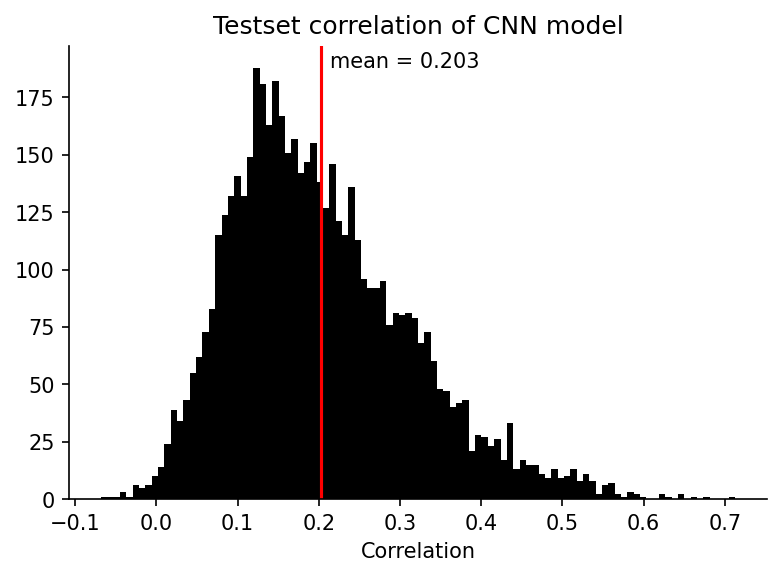

In [184]:
# compute correlation on test set
cnn_test_correlations = measures.get_correlations(
    cnn_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(cnn_test_correlations, bins=100, color='k')
mean_corr = np.mean(cnn_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of CNN model')
ax.set_xlabel('Correlation')
sns.despine()

So on average, it seems to do better than our simple LN model. Let's compare the performance for each neuron between the two models.

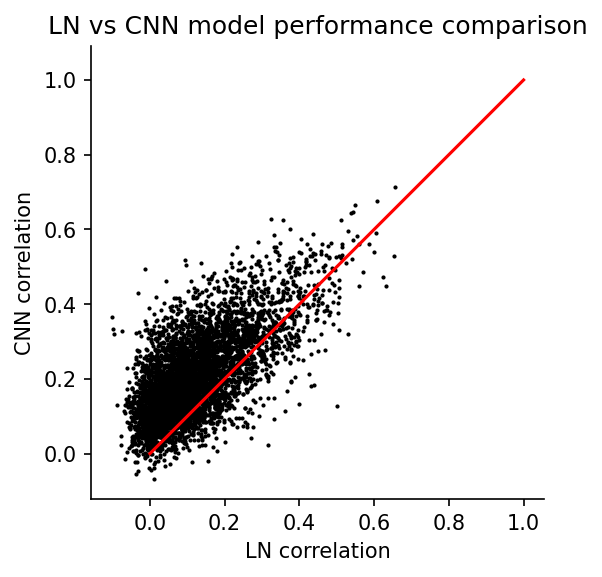

In [188]:
# compare model performance
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(ln_test_correlations, cnn_test_correlations, color="k", s=1)
ax.set_xlabel('LN correlation')
ax.set_ylabel('CNN correlation')
ax.set_title('LN vs CNN model performance comparison')
ax.plot([0, 1], [0, 1], color='r')
ax.axis('square')
sns.despine()

You can appreciate that for vast majority of neurons (each black point), the CNN model yields better predictive performance than the LN model.

## Trying out the State-of-the-Art (SOTA) model

Now that we got some sense on how we could go about training linear and nonlinear network models to predict V1 neuron responses to natural images, and we just saw how using a CNN model brings significant improvement to the performance beyond the LN model.

You might now be wondering, how good can we get? To get a sense of this, let's go ahead and train a state-of-the-art (SOTA) CNN model for mouse V1 responses to natual images as published in our recent work in [Lurz et al. ICLR 2021](https://github.com/sinzlab/Lurz_2020_code).

To keep things simple, I have provided for the network implementation in the `lviv` package, so you can build the model just by invoking a function!

In [189]:
from lviv.models import build_lurz2020_model
model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439
               }

sota_cnn_model = build_lurz2020_model(**model_config, dataloaders=dataloaders, seed=1234)

In [190]:
score, output, model_state = train_model(model=sota_cnn_model, dataloader=dataloaders)

correlation 0.00034033312
poisson_loss 3467926.2


Epoch 1: 100%|██████████| 75/75 [00:03<00:00, 23.75it/s]


[001|00/05] ---> 0.06787307560443878
correlation 0.067873076
poisson_loss 1935524.5


Epoch 2: 100%|██████████| 75/75 [00:03<00:00, 23.51it/s]


[002|00/05] ---> 0.10996364057064056
correlation 0.10996364
poisson_loss 1894918.6


Epoch 3: 100%|██████████| 75/75 [00:03<00:00, 24.14it/s]


[003|00/05] ---> 0.1375318467617035
correlation 0.13753185
poisson_loss 1863867.0


Epoch 4: 100%|██████████| 75/75 [00:03<00:00, 24.61it/s]


[004|00/05] ---> 0.16539742052555084
correlation 0.16539742
poisson_loss 1837474.8


Epoch 5: 100%|██████████| 75/75 [00:03<00:00, 24.70it/s]


[005|00/05] ---> 0.1886771321296692
correlation 0.18867713
poisson_loss 1809697.5


Epoch 6: 100%|██████████| 75/75 [00:03<00:00, 24.73it/s]


[006|00/05] ---> 0.20710888504981995
correlation 0.20710889
poisson_loss 1788869.2


Epoch 7: 100%|██████████| 75/75 [00:03<00:00, 24.85it/s]


[007|00/05] ---> 0.2210845947265625
correlation 0.2210846
poisson_loss 1776406.6


Epoch 8: 100%|██████████| 75/75 [00:03<00:00, 23.44it/s]


[008|00/05] ---> 0.22940734028816223
correlation 0.22940734
poisson_loss 1774091.2


Epoch 9: 100%|██████████| 75/75 [00:03<00:00, 24.51it/s]


[009|00/05] ---> 0.2410404235124588
correlation 0.24104042
poisson_loss 1752204.5


Epoch 10: 100%|██████████| 75/75 [00:03<00:00, 24.37it/s]


[010|00/05] ---> 0.2530755400657654
correlation 0.25307554
poisson_loss 1736116.6


Epoch 11: 100%|██████████| 75/75 [00:03<00:00, 24.80it/s]


[011|00/05] ---> 0.26200374960899353
correlation 0.26200375
poisson_loss 1726259.4


Epoch 12: 100%|██████████| 75/75 [00:03<00:00, 23.58it/s]


[012|01/05] -/-> 0.26140353083610535
correlation 0.26140353
poisson_loss 1732223.8


Epoch 13: 100%|██████████| 75/75 [00:03<00:00, 23.82it/s]


[013|01/05] ---> 0.2666929066181183
correlation 0.2666929
poisson_loss 1719308.0


Epoch 14: 100%|██████████| 75/75 [00:03<00:00, 24.10it/s]


[014|00/05] ---> 0.27275601029396057
correlation 0.272756
poisson_loss 1715621.9


Epoch 15: 100%|██████████| 75/75 [00:03<00:00, 24.38it/s]


[015|00/05] ---> 0.2757464647293091
correlation 0.27574646
poisson_loss 1706096.2


Epoch 16: 100%|██████████| 75/75 [00:03<00:00, 23.69it/s]


[016|00/05] ---> 0.27953892946243286
correlation 0.27953893
poisson_loss 1705926.1


Epoch 17: 100%|██████████| 75/75 [00:03<00:00, 23.45it/s]


[017|01/05] -/-> 0.27851811051368713
correlation 0.2785181
poisson_loss 1702321.5


Epoch 18: 100%|██████████| 75/75 [00:03<00:00, 23.73it/s]


[018|01/05] ---> 0.28035420179367065
correlation 0.2803542
poisson_loss 1700415.2


Epoch 19: 100%|██████████| 75/75 [00:03<00:00, 23.76it/s]


[019|00/05] ---> 0.28100690245628357
correlation 0.2810069
poisson_loss 1702571.2


Epoch 20: 100%|██████████| 75/75 [00:03<00:00, 23.53it/s]


[020|00/05] ---> 0.28109103441238403
correlation 0.28109103
poisson_loss 1701695.4


Epoch 21: 100%|██████████| 75/75 [00:03<00:00, 24.10it/s]


[021|00/05] ---> 0.28441017866134644
correlation 0.28441018
poisson_loss 1697016.2


Epoch 22: 100%|██████████| 75/75 [00:03<00:00, 23.80it/s]


[022|01/05] -/-> 0.2838843762874603
correlation 0.28388438
poisson_loss 1698947.2


Epoch 23: 100%|██████████| 75/75 [00:03<00:00, 20.24it/s]


[023|01/05] ---> 0.2875996530056
correlation 0.28759965
poisson_loss 1692793.8


Epoch 24: 100%|██████████| 75/75 [00:03<00:00, 23.29it/s]


[024|01/05] -/-> 0.2802520990371704
correlation 0.2802521
poisson_loss 1707437.5


Epoch 25: 100%|██████████| 75/75 [00:03<00:00, 23.47it/s]


[025|02/05] -/-> 0.2814634442329407
correlation 0.28146344
poisson_loss 1706788.6


Epoch 26: 100%|██████████| 75/75 [00:03<00:00, 24.09it/s]


[026|03/05] -/-> 0.28642547130584717
correlation 0.28642547
poisson_loss 1697333.8


Epoch 27: 100%|██████████| 75/75 [00:03<00:00, 24.36it/s]


[027|04/05] -/-> 0.2831057608127594
correlation 0.28310576
poisson_loss 1705624.2


Epoch 28: 100%|██████████| 75/75 [00:03<00:00, 24.52it/s]


[028|05/05] -/-> 0.28724056482315063
Restoring best model after lr decay! 0.287241 ---> 0.287600
correlation 0.28759965
poisson_loss 1692793.8


Epoch 29: 100%|██████████| 75/75 [00:03<00:00, 23.64it/s]


Epoch    29: reducing learning rate of group 0 to 1.5000e-03.
[029|01/05] -/-> 0.2806972563266754
correlation 0.28069726
poisson_loss 1707878.4


Epoch 30: 100%|██████████| 75/75 [00:03<00:00, 24.05it/s]


[030|01/05] ---> 0.29481175541877747
correlation 0.29481176
poisson_loss 1679872.0


Epoch 31: 100%|██████████| 75/75 [00:03<00:00, 24.64it/s]


[031|00/05] ---> 0.29728567600250244
correlation 0.29728568
poisson_loss 1678024.9


Epoch 32: 100%|██████████| 75/75 [00:03<00:00, 24.52it/s]


[032|01/05] -/-> 0.29440122842788696
correlation 0.29440123
poisson_loss 1681929.2


Epoch 33: 100%|██████████| 75/75 [00:03<00:00, 23.19it/s]


[033|02/05] -/-> 0.29145699739456177
correlation 0.291457
poisson_loss 1686285.4


Epoch 34: 100%|██████████| 75/75 [00:03<00:00, 23.40it/s]


[034|03/05] -/-> 0.2954012453556061
correlation 0.29540125
poisson_loss 1684492.0


Epoch 35: 100%|██████████| 75/75 [00:03<00:00, 23.81it/s]


[035|04/05] -/-> 0.28988325595855713
correlation 0.28988326
poisson_loss 1687171.6


Epoch 36: 100%|██████████| 75/75 [00:03<00:00, 23.52it/s]


[036|05/05] -/-> 0.28831052780151367
Restoring best model after lr decay! 0.288311 ---> 0.297286
correlation 0.29728568
poisson_loss 1678024.9


Epoch 37: 100%|██████████| 75/75 [00:03<00:00, 24.53it/s]


Epoch    37: reducing learning rate of group 0 to 4.5000e-04.
[037|01/05] -/-> 0.2952514886856079
correlation 0.2952515
poisson_loss 1681833.0


Epoch 38: 100%|██████████| 75/75 [00:03<00:00, 23.84it/s]


[038|02/05] -/-> 0.29708340764045715
correlation 0.2970834
poisson_loss 1677903.0


Epoch 39: 100%|██████████| 75/75 [00:03<00:00, 23.63it/s]


[039|03/05] -/-> 0.2962174713611603
correlation 0.29621747
poisson_loss 1677434.4


Epoch 40: 100%|██████████| 75/75 [00:03<00:00, 23.34it/s]


[040|04/05] -/-> 0.29502999782562256
correlation 0.29503
poisson_loss 1681873.8


Epoch 41: 100%|██████████| 75/75 [00:03<00:00, 23.45it/s]


[041|05/05] -/-> 0.2950746417045593
Restoring best model after lr decay! 0.295075 ---> 0.297286
Restoring best model! 0.297286 ---> 0.297286


As usual, let's take a look at the testset performance.

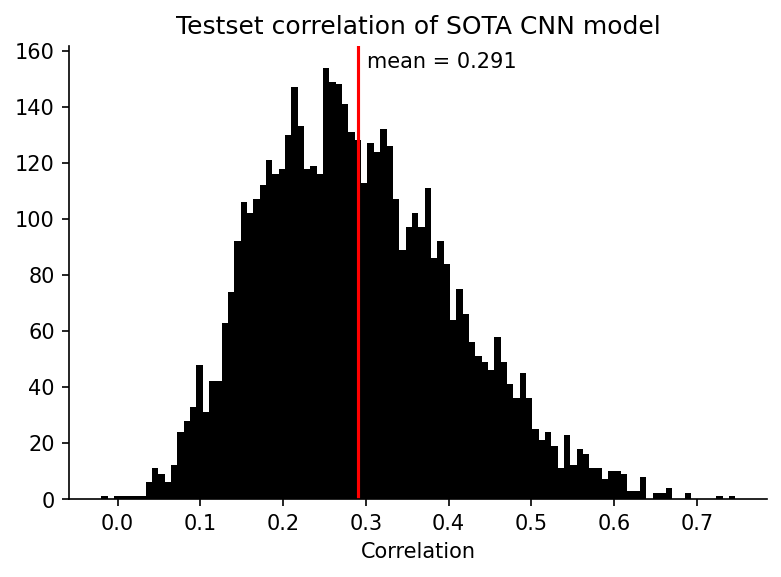

In [194]:
# compute correlation on test set
sota_cnn_test_correlations = measures.get_correlations(
    sota_cnn_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(sota_cnn_test_correlations, bins=100, color='k')
mean_corr = np.mean(sota_cnn_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of SOTA CNN model')
ax.set_xlabel('Correlation')
sns.despine()

It turns out that we can have *linearized* version of the SOTA model. This effectively removes all nonlinear operations within the network except for the very last nonlinear activation, rendering the network into a **LN model** but with more complex architecture.

In [196]:
linear_model_config = dict(model_config) # copy the config
linear_model_config['linear'] = True # set linear to True to make it a LN model!

sota_ln_model = build_lurz2020_model(**linear_model_config, dataloaders=dataloaders, seed=1234)

In [197]:
score, output, model_state = train_model(model=sota_ln_model, dataloader=dataloaders)

correlation 0.00037260386
poisson_loss 3467901.0


Epoch 1: 100%|██████████| 75/75 [00:03<00:00, 23.81it/s]


[001|00/05] ---> 0.031154120340943336
correlation 0.03115412
poisson_loss 2004979.6


Epoch 2: 100%|██████████| 75/75 [00:03<00:00, 24.24it/s]


[002|00/05] ---> 0.06628101319074631
correlation 0.06628101
poisson_loss 1938707.6


Epoch 3: 100%|██████████| 75/75 [00:03<00:00, 23.89it/s]


[003|00/05] ---> 0.10129044204950333
correlation 0.10129044
poisson_loss 1896883.6


Epoch 4: 100%|██████████| 75/75 [00:03<00:00, 24.27it/s]


[004|00/05] ---> 0.11133434623479843
correlation 0.111334346
poisson_loss 1889438.8


Epoch 5: 100%|██████████| 75/75 [00:03<00:00, 23.81it/s]


[005|00/05] ---> 0.1422801911830902
correlation 0.14228019
poisson_loss 1866141.4


Epoch 6: 100%|██████████| 75/75 [00:03<00:00, 24.76it/s]


[006|00/05] ---> 0.1523531973361969
correlation 0.1523532
poisson_loss 1856250.8


Epoch 7: 100%|██████████| 75/75 [00:03<00:00, 23.95it/s]


[007|00/05] ---> 0.1694387048482895
correlation 0.1694387
poisson_loss 1838175.6


Epoch 8: 100%|██████████| 75/75 [00:03<00:00, 25.00it/s]


[008|00/05] ---> 0.17451056838035583
correlation 0.17451057
poisson_loss 1830370.5


Epoch 9: 100%|██████████| 75/75 [00:03<00:00, 24.17it/s]


[009|00/05] ---> 0.18366901576519012
correlation 0.18366902
poisson_loss 1819281.1


Epoch 10: 100%|██████████| 75/75 [00:03<00:00, 23.80it/s]


[010|00/05] ---> 0.18900378048419952
correlation 0.18900378
poisson_loss 1814585.8


Epoch 11: 100%|██████████| 75/75 [00:03<00:00, 23.57it/s]


[011|00/05] ---> 0.19559316337108612
correlation 0.19559316
poisson_loss 1809078.8


Epoch 12: 100%|██████████| 75/75 [00:03<00:00, 23.64it/s]


[012|00/05] ---> 0.19598908722400665
correlation 0.19598909
poisson_loss 1812337.2


Epoch 13: 100%|██████████| 75/75 [00:03<00:00, 23.85it/s]


[013|00/05] ---> 0.19925911724567413
correlation 0.19925912
poisson_loss 1802411.1


Epoch 14: 100%|██████████| 75/75 [00:03<00:00, 23.96it/s]


[014|01/05] -/-> 0.19721285998821259
correlation 0.19721286
poisson_loss 1813778.1


Epoch 15: 100%|██████████| 75/75 [00:03<00:00, 23.68it/s]


[015|01/05] ---> 0.19943396747112274
correlation 0.19943397
poisson_loss 1805019.9


Epoch 16: 100%|██████████| 75/75 [00:02<00:00, 25.11it/s]


[016|00/05] ---> 0.20473770797252655
correlation 0.20473771
poisson_loss 1800555.1


Epoch 17: 100%|██████████| 75/75 [00:03<00:00, 24.19it/s]


[017|01/05] -/-> 0.20269884169101715
correlation 0.20269884
poisson_loss 1800096.5


Epoch 18: 100%|██████████| 75/75 [00:03<00:00, 23.90it/s]


[018|01/05] ---> 0.2061077207326889
correlation 0.20610772
poisson_loss 1795254.0


Epoch 19: 100%|██████████| 75/75 [00:03<00:00, 23.87it/s]


[019|01/05] -/-> 0.20485205948352814
correlation 0.20485206
poisson_loss 1798792.5


Epoch 20: 100%|██████████| 75/75 [00:03<00:00, 23.81it/s]


[020|02/05] -/-> 0.2048516720533371
correlation 0.20485167
poisson_loss 1797439.4


Epoch 21: 100%|██████████| 75/75 [00:03<00:00, 23.53it/s]


[021|02/05] ---> 0.20937415957450867
correlation 0.20937416
poisson_loss 1793138.4


Epoch 22: 100%|██████████| 75/75 [00:03<00:00, 24.88it/s]


[022|01/05] -/-> 0.20609386265277863
correlation 0.20609386
poisson_loss 1797882.2


Epoch 23: 100%|██████████| 75/75 [00:03<00:00, 23.52it/s]


[023|02/05] -/-> 0.20404353737831116
correlation 0.20404354
poisson_loss 1799685.6


Epoch 24: 100%|██████████| 75/75 [00:03<00:00, 23.73it/s]


[024|03/05] -/-> 0.20454750955104828
correlation 0.20454751
poisson_loss 1798025.9


Epoch 25: 100%|██████████| 75/75 [00:03<00:00, 23.99it/s]


[025|03/05] ---> 0.20941472053527832
correlation 0.20941472
poisson_loss 1793924.2


Epoch 26: 100%|██████████| 75/75 [00:03<00:00, 24.90it/s]


[026|01/05] -/-> 0.20531687140464783
correlation 0.20531687
poisson_loss 1796690.5


Epoch 27: 100%|██████████| 75/75 [00:03<00:00, 25.00it/s]


[027|02/05] -/-> 0.20843307673931122
correlation 0.20843308
poisson_loss 1792562.0


Epoch 28: 100%|██████████| 75/75 [00:03<00:00, 24.12it/s]


[028|03/05] -/-> 0.20856915414333344
correlation 0.20856915
poisson_loss 1793297.0


Epoch 29: 100%|██████████| 75/75 [00:03<00:00, 24.91it/s]


[029|03/05] ---> 0.21146723628044128
correlation 0.21146724
poisson_loss 1791831.0


Epoch 30: 100%|██████████| 75/75 [00:03<00:00, 23.65it/s]


[030|01/05] -/-> 0.20582225918769836
correlation 0.20582226
poisson_loss 1795871.8


Epoch 31: 100%|██████████| 75/75 [00:02<00:00, 25.05it/s]


[031|02/05] -/-> 0.20788462460041046
correlation 0.20788462
poisson_loss 1791888.0


Epoch 32: 100%|██████████| 75/75 [00:02<00:00, 25.15it/s]


[032|02/05] ---> 0.21289031207561493
correlation 0.21289031
poisson_loss 1788401.1


Epoch 33: 100%|██████████| 75/75 [00:03<00:00, 23.82it/s]


[033|00/05] ---> 0.2130030393600464
correlation 0.21300304
poisson_loss 1788108.2


Epoch 34: 100%|██████████| 75/75 [00:03<00:00, 23.84it/s]


[034|01/05] -/-> 0.21205812692642212
correlation 0.21205813
poisson_loss 1790667.8


Epoch 35: 100%|██████████| 75/75 [00:03<00:00, 24.95it/s]


[035|02/05] -/-> 0.2101009488105774
correlation 0.21010095
poisson_loss 1789697.5


Epoch 36: 100%|██████████| 75/75 [00:03<00:00, 23.59it/s]


[036|03/05] -/-> 0.20937992632389069
correlation 0.20937993
poisson_loss 1793023.4


Epoch 37: 100%|██████████| 75/75 [00:03<00:00, 23.44it/s]


[037|04/05] -/-> 0.2109660506248474
correlation 0.21096605
poisson_loss 1791269.8


Epoch 38: 100%|██████████| 75/75 [00:03<00:00, 23.56it/s]


[038|05/05] -/-> 0.21128803491592407
Restoring best model after lr decay! 0.211288 ---> 0.213003
correlation 0.21300304
poisson_loss 1788108.2


Epoch 39: 100%|██████████| 75/75 [00:03<00:00, 24.45it/s]


Epoch    39: reducing learning rate of group 0 to 1.5000e-03.
[039|01/05] -/-> 0.20972859859466553
correlation 0.2097286
poisson_loss 1791484.4


Epoch 40: 100%|██████████| 75/75 [00:03<00:00, 23.66it/s]


[040|01/05] ---> 0.21579156816005707
correlation 0.21579157
poisson_loss 1781386.6


Epoch 41: 100%|██████████| 75/75 [00:03<00:00, 24.31it/s]


[041|01/05] -/-> 0.2157527655363083
correlation 0.21575277
poisson_loss 1781553.0


Epoch 42: 100%|██████████| 75/75 [00:03<00:00, 23.97it/s]


[042|01/05] ---> 0.21590964496135712
correlation 0.21590964
poisson_loss 1783046.2


Epoch 43: 100%|██████████| 75/75 [00:03<00:00, 24.96it/s]


[043|01/05] -/-> 0.21569781005382538
correlation 0.21569781
poisson_loss 1783103.1


Epoch 44: 100%|██████████| 75/75 [00:03<00:00, 23.70it/s]


[044|02/05] -/-> 0.21519061923027039
correlation 0.21519062
poisson_loss 1782805.5


Epoch 45: 100%|██████████| 75/75 [00:03<00:00, 24.61it/s]


[045|03/05] -/-> 0.21451957523822784
correlation 0.21451958
poisson_loss 1782807.6


Epoch 46: 100%|██████████| 75/75 [00:03<00:00, 23.88it/s]


[046|04/05] -/-> 0.21560446918010712
correlation 0.21560447
poisson_loss 1787998.4


Epoch 47: 100%|██████████| 75/75 [00:03<00:00, 24.81it/s]


[047|05/05] -/-> 0.21534429490566254
Restoring best model after lr decay! 0.215344 ---> 0.215910
correlation 0.21590964
poisson_loss 1783046.2


Epoch 48: 100%|██████████| 75/75 [00:02<00:00, 25.11it/s]


Epoch    48: reducing learning rate of group 0 to 4.5000e-04.
[048|01/05] -/-> 0.21533653140068054
correlation 0.21533653
poisson_loss 1785094.5


Epoch 49: 100%|██████████| 75/75 [00:03<00:00, 24.99it/s]


[049|01/05] ---> 0.21647505462169647
correlation 0.21647505
poisson_loss 1780531.8


Epoch 50: 100%|██████████| 75/75 [00:03<00:00, 23.91it/s]


[050|00/05] ---> 0.21651552617549896
correlation 0.21651553
poisson_loss 1782287.0


Epoch 51: 100%|██████████| 75/75 [00:03<00:00, 24.97it/s]


[051|01/05] -/-> 0.21584616601467133
correlation 0.21584617
poisson_loss 1781882.2


Epoch 52: 100%|██████████| 75/75 [00:03<00:00, 24.19it/s]


[052|02/05] -/-> 0.21620571613311768
correlation 0.21620572
poisson_loss 1781055.1


Epoch 53: 100%|██████████| 75/75 [00:03<00:00, 23.84it/s]


[053|03/05] -/-> 0.21597759425640106
correlation 0.2159776
poisson_loss 1781875.1


Epoch 54: 100%|██████████| 75/75 [00:03<00:00, 24.00it/s]


[054|04/05] -/-> 0.21607860922813416
correlation 0.21607861
poisson_loss 1781580.5


Epoch 55: 100%|██████████| 75/75 [00:03<00:00, 23.45it/s]


[055|05/05] -/-> 0.21634235978126526
Restoring best model after lr decay! 0.216342 ---> 0.216516
Restoring best model! 0.216516 ---> 0.216516


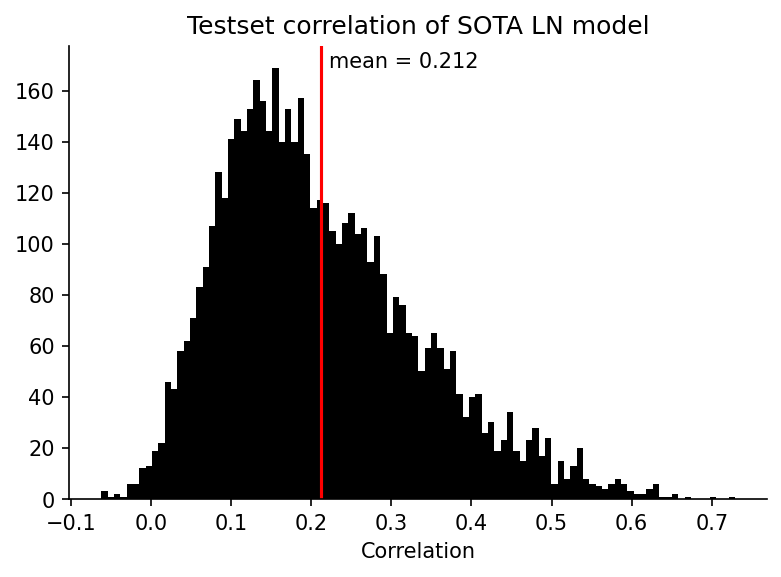

In [198]:
# compute correlation on test set
sota_ln_test_correlations = measures.get_correlations(
    sota_ln_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(sota_ln_test_correlations, bins=100, color='k')
mean_corr = np.mean(sota_ln_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of SOTA LN model')
ax.set_xlabel('Correlation')
sns.despine()

Interestingly, you can see that compared to our simple LN model, the SOTA LN model actually attains much better performance. This, among other things, reflects the **ease of training** the CNN based network compared to our *fully-connected* simple linear model. Despite the architectural complexity of the SOTA LN model, it is still a LN model as was described mathematically as:

$$
\mathbf{r} = a(\mathbf{U} x + \mathbf{b})
$$

### Compare model performance between SOTA CNN and SOTA LN model

Just as before, let's compare the performanc of SOTA CNN vs SOTA LN.

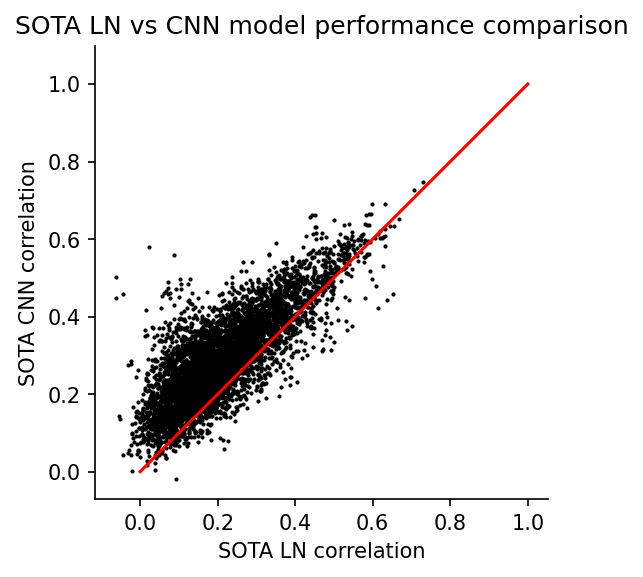

In [200]:
# compare model performance
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(sota_ln_test_correlations, sota_cnn_test_correlations, color="k", s=1)
ax.set_xlabel('SOTA LN correlation')
ax.set_ylabel('SOTA CNN correlation')
ax.set_title('SOTA LN vs CNN model performance comparison')
ax.plot([0, 1], [0, 1], color='r')
ax.axis('square')
sns.despine()

We can see that SOTA CNN model still performans better than the SOTA LN model across most of the neurons.

# Analyzing the trained models to gain insights into the brain

<font color='green'>
    NOTE to collaborators: 
    Please provide code for generating gradient receptive field and MEI for the sota networks. By this point, they should have `sota_model` and `sota_ln_model` corresponding to the best nonlinear and linear model based on the model architecture as found in Lurz et al. 2021.
</font>

In [ ]:
# select neuron to compute RFs and MEIs
neuron_idx = 1
# choose input mean as starting point
input_mean = np.load(
    "/content/data/static20457-5-9-preproc0/meta/statistics/images/all/mean.npy"
).squeeze()
input_std =np.load(
    "/content/data/static20457-5-9-preproc0/meta/statistics/images/all/std.npy"
).squeeze()

In [ ]:
def generate_grad_rf(model, starting_point, neuron_idx):
    assert starting_point.ndim == 2
    x = torch.tensor(
        starting_point.copy()[None, None, ...],
        dtype=torch.float,
        device="cuda",
        requires_grad=True,
    )
    model_activation = model(x)[:, neuron_idx]
    model_activation.backward()
    grad_rf = x.grad.data.cpu().numpy().squeeze()
    return grad_rf


# generate a gradient receptive field from the sota_model and the sota_ln_model
grad_rf_sota = generate_grad_rf(
    sota_model, starting_point=np.ones((36, 64)) * input_mean, neuron_idx=neuron_idx
)
grad_rf_sota_ln = generate_grad_rf(
    sota_ln_model, starting_point=np.ones((36, 64)) * input_mean, neuron_idx=neuron_idx
)

# compare the two grad_rfs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(grad_rf_sota, cmap="gray")
axes[0].set_title("SOTA")
axes[0].axis("off")
axes[1].imshow(grad_rf_sota_ln, cmap="gray")
axes[1].set_title("SOTA_ln")
axes[1].axis("off")
plt.suptitle("Gradient receptive fields", y=0.8)


In [ ]:
from tqdm import tqdm


def generate_mei(
    model,
    starting_point,
    neuron_idx,
    iterations,
    mean_constr,
    std_constr=1,
    lr=1,
    disable_progress_bar=False,
):
    std_constr = torch.tensor(std_constr).cuda()
    mean_constr = torch.tensor(mean_constr).cuda()
    assert starting_point.ndim == 2
    x = torch.tensor(
        starting_point.copy()[None, None, ...],
        dtype=torch.float,
        device="cuda",
        requires_grad=True,
    )
    optimizer = torch.optim.SGD([x], lr=lr, momentum=0.9)
    model_activations = []
    for i in tqdm(range(iterations), disable=disable_progress_bar):
        transformed_x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr
        model_activation = model(transformed_x)[:, neuron_idx]
        (-model_activation).backward()
        model_activations.append(model_activation.detach().cpu().numpy())
        optimizer.step()
    x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr
    return np.array(model_activations), x.detach().cpu().numpy().squeeze()



In [ ]:
# generate a gradient receptive field from the sota_model and the sota_ln_model
activation_sota, mei_sota = generate_mei(
    sota_model,
    starting_point=np.random.normal(input_mean, input_std / 10, (36, 64)),
    neuron_idx=neuron_idx,
    iterations=2000,
    mean_constr=input_mean,
    std_constr=input_std / 10,
    lr=100,
)

activation_sota_ln, mei_sota_ln = generate_mei(
    sota_ln_model,
    starting_point=np.random.normal(input_mean, input_std / 10, (36, 64)),
    neuron_idx=neuron_idx,
    iterations=2000,
    mean_constr=input_mean,
    std_constr=input_std / 10,
    lr=100,
)


In [ ]:
# compare the two meis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes[0,0].imshow(mei_sota, cmap='gray')
axes[0,0].axis('off')
axes[0,0].set_title('SOTA')
axes[1,0].plot(activation_sota)
axes[1,0].set_ylabel('SOTA model activation')
axes[1,0].set_xlabel('Iterations')
axes[0,1].imshow(mei_sota_ln, cmap='gray')
axes[0,1].axis('off')
axes[0,1].set_title('SOTA_ln')
axes[1,1].plot(activation_sota_ln)
axes[1,1].set_ylabel('SOTA_ln model activation')
axes[1,1].set_xlabel('Iterations')
plt.suptitle('MEIs', y=1.02)

### MEI cross activation

In [ ]:
neuron_idx_ls = np.random.randint(0, high=5335, size=20)
meis = []
for i in tqdm(neuron_idx_ls):
    _, mei = generate_mei(
            sota_model,
            starting_point=np.random.normal(input_mean, input_std / 10, (36, 64)),
            neuron_idx=i,
            iterations=2000,
            mean_constr=input_mean,
            std_constr=input_std / 10,
            disable_progress_bar=True,
    )
    meis.append(mei)


In [ ]:
meis = torch.tensor(np.stack(meis))[:, None, ...].cuda()
activations = sota_model(meis).cpu().detach().numpy().squeeze()[:, neuron_idx_ls]
activations = activations / activations.max(axis=0, keepdims=True)
plt.imshow(activations, cmap='gray')
plt.ylabel('MEIs')
plt.xlabel('Neurons')